<a href="https://colab.research.google.com/github/chumdan/Machine-Learning-Project/blob/main/Deep%20Learning%20Project/%EC%84%B1%EB%B3%84%EA%B3%BC_%EC%9B%83%EC%9D%8C_%EC%97%AC%EB%B6%80_%EB%8F%99%EC%8B%9C_%ED%8C%90%EB%8B%A8%EB%AA%A8%EB%8D%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 주제 : 성별과 웃음 여부를 동시에 판단하는 모델

## 데이터  
- 작게 줄인 celeba 데이터

## 목표
- 한 모델에서 여러 결과에 대한 분석
- 작게 줄인 celeba 데이터를 이용하여 웃음, 성별 동시 구분

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
from IPython.display import Image

warnings.filterwarnings('ignore')
%matplotlib inline

SEED = 34

## Step 1. 데이터전처리

### 데이터 불러오기 및 기본적 형태 확인

In [3]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [4]:
!ls -al /gdrive/'My Drive'/'Colab Notebooks'/dataset/celeba_small.npz

-rw------- 1 root root 173961605 Apr  9 05:38 '/gdrive/My Drive/Colab Notebooks/dataset/celeba_small.npz'


In [5]:
# 예시 이미지 한장 가져오기.
celeba_small = np.load('/gdrive/MyDrive/Colab Notebooks/dataset/celeba_small.npz')
x = celeba_small['train_images'][2]
y = celeba_small['train_labels'][2]

In [6]:
x.shape, y.shape
x.shape, y.shape

((72, 59, 3), (2,))

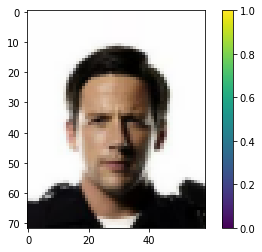

[1 0]


In [7]:
plt.imshow(x)
plt.colorbar()
plt.show()
print(y)

### celeba_small.npz 데이터에서 학습, 테스트 데이터 로드

In [8]:

celeba_small = np.load('/gdrive/MyDrive/Colab Notebooks/dataset/celeba_small.npz')
train_images = celeba_small['train_images']
train_labels = celeba_small['train_labels']

test_images = celeba_small['test_images']
test_labels = celeba_small['test_labels']

In [9]:
print(train_images.dtype)
print(train_labels.dtype)
print(test_images.dtype)
print(test_labels.dtype)

float64
int8
float64
int8


### 이미지 데이터의 범위 확인 

In [10]:
print(train_images.shape, test_images.shape)
print(train_images.dtype, test_images.dtype)


print(train_labels.shape, test_labels.shape)
print(train_labels.dtype, test_labels.dtype)

print(train_images[train_images != 0][:10])
print(test_images[test_images != 0][:10])

(2000, 72, 59, 3) (200, 72, 59, 3)
float64 float64
(2000, 2) (200, 2)
int8 int8
[0.02352941 0.04313725 0.05490196 0.01960784 0.03921569 0.05490196
 0.01977401 0.03921569 0.05114656 0.02352941]
[0.52571083 0.90221419 0.8707544  0.56460618 0.95304088 0.91372549
 0.55277501 0.94885344 0.90571618 0.55756065]


In [11]:
# images/labels 이미지 데이터의 최소/최대값
print(train_images.min(), train_images.max())
print(train_labels.min(), train_labels.max())

0.0 1.0
0 1


### 분석하기 편하도록 shape형태 변경

In [12]:
from keras.utils import to_categorical
#  (배치, (성별,웃음)) => (배치, 남자, 여자), (배치, 웃음, 안웃음)
train_male_labels, train_smile_labels = np.split(train_labels, 2, axis=1)
test_male_labels, test_smile_labels = np.split(test_labels, 2, axis=1)

print(train_male_labels.shape, train_smile_labels.shape)
print(train_male_labels[0], train_smile_labels[0], train_labels[0])

(2000, 1) (2000, 1)
[0] [0] [0 0]


In [13]:
# 원핫 인코딩
train_male_labels = to_categorical(train_male_labels)
train_smile_labels = to_categorical(train_smile_labels)
test_male_labels = to_categorical(test_male_labels)
test_smile_labels = to_categorical(test_smile_labels)

In [14]:
print(train_male_labels.shape, train_smile_labels.shape)
print(test_male_labels.shape, test_smile_labels.shape)

(2000, 2) (2000, 2)
(200, 2) (200, 2)


In [15]:
# 최종적으로 labels의 shape을 (배치, 2), (배치, 2)에서 (배치, 4)로 결합
# concatenate 사용
train_labels2 = np.concatenate([train_male_labels, train_smile_labels], axis = 1)
test_labels2 = np.concatenate([test_male_labels, test_smile_labels], axis = 1)
print(train_labels2.shape, test_labels2.shape)

(2000, 4) (200, 4)


## Step 2. 시각화

### 이미지 5장 시각화

In [16]:
train_images[:5].shape

(5, 72, 59, 3)

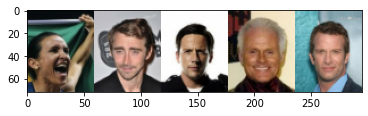

In [17]:
# transpose 활용하여 plt 옆으로 출력

plt.imshow(train_images[:5].transpose((1, 0, 2, 3)).reshape((72, -1, 3)))
plt.show()

In [18]:
# smile, male label출력

for male, smile in zip(train_male_labels[:5], train_smile_labels[:5]):
  print(male, smile)

[1. 0.] [1. 0.]
[0. 1.] [0. 1.]
[0. 1.] [1. 0.]
[0. 1.] [0. 1.]
[0. 1.] [0. 1.]


### smile, male이 각각 몇개 있는지 측정

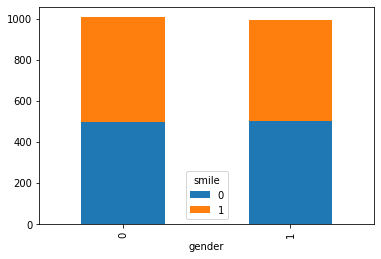

In [19]:
df = pd.DataFrame(train_labels, columns = ['gender', 'smile'])
df.groupby(['gender', 'smile']).size().unstack().plot(kind='bar', stacked=True)

## Step3. 멀티 아웃풋 모델(같은 파라미터를 공유하기 때문에 합쳐서 진행)

In [20]:
# input (배치, 72, 59, 3), output (배치, 4)을 처리할 수 있는 모양의 모델
from keras.models import Model
from keras.layers import Conv2D, MaxPool2D, Input, Dense, Flatten, Concatenate

def multi_model():
  inputs = Input((72, 59, 3))

  l1 = Conv2D(32, 3, activation='relu')(inputs)
  l2 = MaxPool2D(2)(l1)
  l3 = Conv2D(64, 3, activation='relu')(l2)
  l4 = MaxPool2D(2)(l3)
  l5 = Conv2D(64, 3, activation='relu')(l4)
  l6 = MaxPool2D(2)(l5)
  
  l7 = Flatten()(l6)
  latent_vector = Dense(64, activation='relu')(l7)
  
# 레이어 공유
  gender_outputs = Dense(2, activation='softmax')(latent_vector)
  smile_outputs = Dense(2, activation='softmax')(latent_vector)
# Concatenate 활용하여 결합
  outputs = Concatenate(axis=1)([gender_outputs, smile_outputs])
  model = Model(inputs, outputs)
  return model

In [21]:
def multi_model2():
  inputs = Input((72, 59, 3))

  l1 = Conv2D(32, 3, activation='relu')(inputs)
  l2 = MaxPool2D(2)(l1)
  l3 = Conv2D(64, 3, activation='relu')(l2)
  l4 = MaxPool2D(2)(l3)
  l5 = Conv2D(64, 3, activation='relu')(l4)
  l6 = MaxPool2D(2)(l5)
  
  l7 = Flatten()(l6)
  latent_vector = Dense(64, activation='relu')(l7)
# 레이어공유
  gender_outputs = Dense(2, activation='softmax')(latent_vector)
  smile_outputs = Dense(2, activation='softmax')(latent_vector)

# 리스트형식으로 결합
  model = Model(inputs, [gender_outputs, smile_outputs])
  return model

In [22]:
model = multi_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 72, 59, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 70, 57, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 35, 28, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 33, 26, 64)   18496       max_pooling2d[0][0]              
______________________________________________________________________________________________

In [23]:
model2 = multi_model2()
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 72, 59, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 70, 57, 32)   896         input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 35, 28, 32)   0           conv2d_3[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 33, 26, 64)   18496       max_pooling2d_3[0][0]            
____________________________________________________________________________________________

In [24]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Step4. 학습 및 결과

In [25]:
hist1 = model.fit(train_images, train_labels2, validation_data=(test_images, test_labels2), epochs=15, verbose=1)

Epoch 1/15
63/63 [==============================] - 31s 21ms/step - loss: 2.7376 - accuracy: 0.4324 - val_loss: 2.6931 - val_accuracy: 0.5550
Epoch 2/15
63/63 [==============================] - 1s 13ms/step - loss: 2.5197 - accuracy: 0.6131 - val_loss: 2.3467 - val_accuracy: 0.6450
Epoch 3/15
63/63 [==============================] - 1s 12ms/step - loss: 2.1767 - accuracy: 0.6650 - val_loss: 2.0525 - val_accuracy: 0.5750
Epoch 4/15
63/63 [==============================] - 1s 12ms/step - loss: 1.9636 - accuracy: 0.6451 - val_loss: 2.0677 - val_accuracy: 0.5300
Epoch 5/15
63/63 [==============================] - 1s 12ms/step - loss: 1.8080 - accuracy: 0.6534 - val_loss: 1.9617 - val_accuracy: 0.5850
Epoch 6/15
63/63 [==============================] - 1s 12ms/step - loss: 1.7764 - accuracy: 0.6445 - val_loss: 1.9337 - val_accuracy: 0.6200
Epoch 7/15
63/63 [==============================] - 1s 12ms/step - loss: 1.6764 - accuracy: 0.6855 - val_loss: 1.9410 - val_accuracy: 0.5700
Epoch 8/15
6

In [26]:
# 아웃풋이 두개의 리스트기 때문에. 학습도 리스트로.
hist2 = model2.fit(train_images, [train_male_labels, train_smile_labels], validation_data=(test_images, [test_male_labels, test_smile_labels]), epochs=15, verbose=1)

Epoch 1/15
63/63 [==============================] - 2s 21ms/step - loss: 1.3680 - dense_4_loss: 0.6704 - dense_5_loss: 0.6977 - dense_4_accuracy: 0.5805 - dense_5_accuracy: 0.5096 - val_loss: 1.2452 - val_dense_4_loss: 0.5810 - val_dense_5_loss: 0.6642 - val_dense_4_accuracy: 0.7000 - val_dense_5_accuracy: 0.5750
Epoch 2/15
63/63 [==============================] - 1s 15ms/step - loss: 1.1431 - dense_4_loss: 0.4914 - dense_5_loss: 0.6517 - dense_4_accuracy: 0.7583 - dense_5_accuracy: 0.6311 - val_loss: 1.1949 - val_dense_4_loss: 0.5655 - val_dense_5_loss: 0.6293 - val_dense_4_accuracy: 0.7400 - val_dense_5_accuracy: 0.6700
Epoch 3/15
63/63 [==============================] - 1s 15ms/step - loss: 1.0844 - dense_4_loss: 0.4645 - dense_5_loss: 0.6199 - dense_4_accuracy: 0.7837 - dense_5_accuracy: 0.6658 - val_loss: 0.9543 - val_dense_4_loss: 0.4298 - val_dense_5_loss: 0.5245 - val_dense_4_accuracy: 0.8550 - val_dense_5_accuracy: 0.7450
Epoch 4/15
63/63 [==============================] - 1s 

### 학습 진행 사항 plt으로 출력

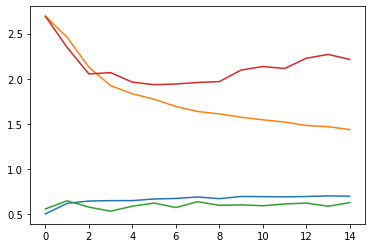

In [27]:
# 1모델 Concatenate 활용한 모델
plt.plot(hist1.history['accuracy'], label = 'accuracy')
plt.plot(hist1.history['loss'], label = 'loss')
plt.plot(hist1.history['val_accuracy'], label = 'val_accuracy')
plt.plot(hist1.history['val_loss'], label = 'val_loss')
plt.show()

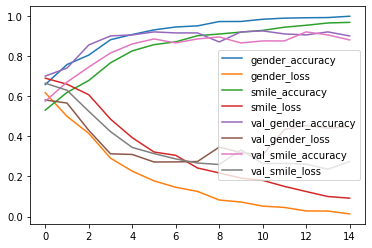

In [29]:
# 2모델 리스트형식으로 결합 모델
plt.plot(hist2.history['dense_4_accuracy'], label = 'gender_accuracy')
plt.plot(hist2.history['dense_4_loss'], label = 'gender_loss')
plt.plot(hist2.history['dense_5_accuracy'], label = 'smile_accuracy')
plt.plot(hist2.history['dense_5_loss'], label = 'smile_loss')

plt.plot(hist2.history['val_dense_4_accuracy'], label = 'val_gender_accuracy')
plt.plot(hist2.history['val_dense_4_loss'], label = 'val_gender_loss')
plt.plot(hist2.history['val_dense_5_accuracy'], label = 'val_smile_accuracy')
plt.plot(hist2.history['val_dense_5_loss'], label = 'val_smile_loss')
plt.legend(loc = 'uppder left')
plt.show()
# 결과가 더 좋음

## Step 4. 결과확인

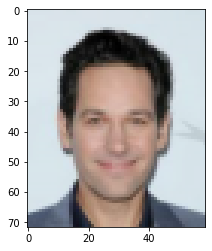

In [30]:
plt.imshow(test_images[3])
plt.show()

In [33]:
# 결합을 한 모델이기 때문에 하나로 나옴
res = model.predict(test_images[3:4])
print(res.shape)

(1, 4)


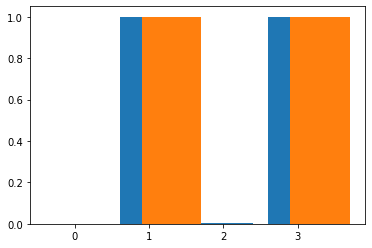

In [34]:
plt.bar(range(4), res[0])
plt.bar(np.array(range(4)) + 0.3, test_labels2[3])
plt.show()
# 남자고, 웃고. -> 잘 맞춤.

In [37]:
# 아웃풋이 두개 이기때문에 두개로 나옴. 결과도 두번 봐야함 
res2 = model2.predict(test_images[3:4])
print(res2[0].shape, res2[1].shape)

(1, 2) (1, 2)


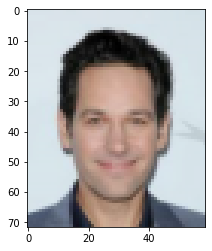

In [38]:
plt.imshow(test_images[3])
plt.show()

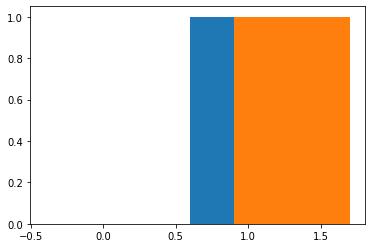

In [39]:
# 남자인지, 여자인지
plt.bar(range(2), res2[0][0])
plt.bar(np.array(range(2)) + 0.3, test_male_labels[3])
plt.show()

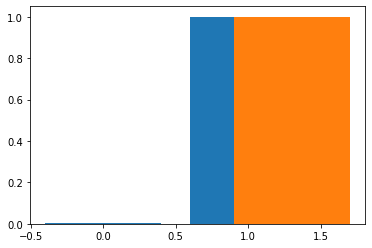

In [40]:
# 웃는지 안웃는지.
plt.bar(range(2), res2[1][0])
plt.bar(np.array(range(2)) + 0.3, test_smile_labels[3])
plt.show()

## Step 5. 모델 분리

In [42]:
# 성별모델 분리
gender_model = Model(inputs = model2.input, outputs = model2.get_layer('dense_4').output)
gender_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 72, 59, 3)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 70, 57, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 35, 28, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 33, 26, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 13, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 5, 64)          0   

In [43]:
gender_model.get_weights()[0][0][0][0]

array([ 0.05214987,  0.19890822, -0.05182765, -0.16475953, -0.07572275,
       -0.0300159 , -0.131279  , -0.10221037,  0.08252021,  0.05151934,
        0.01772383, -0.02108622, -0.08849498, -0.11275187, -0.07227257,
       -0.11716247, -0.0533311 , -0.07772388, -0.02779659,  0.00202916,
        0.10760514,  0.0237334 , -0.08020761,  0.18084869,  0.1602351 ,
       -0.00715726, -0.09272046, -0.14850771, -0.14123072,  0.16343   ,
       -0.08406737, -0.17917727], dtype=float32)

In [44]:
# 성별모델에서 테스트 데이터 확인
x = gender_model.predict(test_images[0:1])
x.argmax()

1

In [45]:
# 스마일모델 분리
smile_model = Model(inputs = model2.input, outputs = model2.get_layer('dense_5').output)
smile_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 72, 59, 3)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 70, 57, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 35, 28, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 33, 26, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 13, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 5, 64)          0   

In [46]:
smile_model.get_weights()[0][0][0][0]

array([ 0.05214987,  0.19890822, -0.05182765, -0.16475953, -0.07572275,
       -0.0300159 , -0.131279  , -0.10221037,  0.08252021,  0.05151934,
        0.01772383, -0.02108622, -0.08849498, -0.11275187, -0.07227257,
       -0.11716247, -0.0533311 , -0.07772388, -0.02779659,  0.00202916,
        0.10760514,  0.0237334 , -0.08020761,  0.18084869,  0.1602351 ,
       -0.00715726, -0.09272046, -0.14850771, -0.14123072,  0.16343   ,
       -0.08406737, -0.17917727], dtype=float32)

In [47]:
# 스마일 모델에서 테스트 데이터 확인
x1 = gender_model.predict(test_images[0:1])
x1.argmax()

1

## Step 6. 모델 저장 및 로드, 다운로드

### 모델저장

In [48]:
model2.save("./lecture004.h5")

In [49]:
# 경로확인
!ls -al /content

total 2424
drwxr-xr-x 1 root root    4096 Apr 16 10:45 .
drwxr-xr-x 1 root root    4096 Apr 16 10:21 ..
drwxr-xr-x 4 root root    4096 Apr  7 13:35 .config
-rw-r--r-- 1 root root 2461880 Apr 16 10:45 lecture004.h5
drwxr-xr-x 1 root root    4096 Apr  7 13:36 sample_data


### 모델로드

In [50]:
model3 = tf.keras.models.load_model('./lecture004.h5')

In [51]:
model3.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 72, 59, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 70, 57, 32)   896         input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 35, 28, 32)   0           conv2d_3[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 33, 26, 64)   18496       max_pooling2d_3[0][0]            
____________________________________________________________________________________________

In [52]:
# 로드한 모델을 test 데이터 평가
model3.evaluate(test_images, [test_male_labels, test_smile_labels])

7/7 [==============================] - 0s 8ms/step - loss: 0.7225 - dense_4_loss: 0.4478 - dense_5_loss: 0.2747 - dense_4_dense_4_accuracy: 0.9000 - dense_5_dense_5_accuracy: 0.8800


[0.7224720120429993,
 0.44775286316871643,
 0.27471911907196045,
 0.8999999761581421,
 0.8799999952316284]

### 모델을 내 컴퓨터에 저장

In [53]:
from google.colab import files
files.download('./lecture004.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>